In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### 1.1 Create the Dataset and Split it into Training and Validation Sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/datasets.zip

Archive:  /content/drive/MyDrive/datasets.zip
replace datasets/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = 'datasets/'
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            validation_split=0.2,
                                            subset='validation',
                                            seed=42)


Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


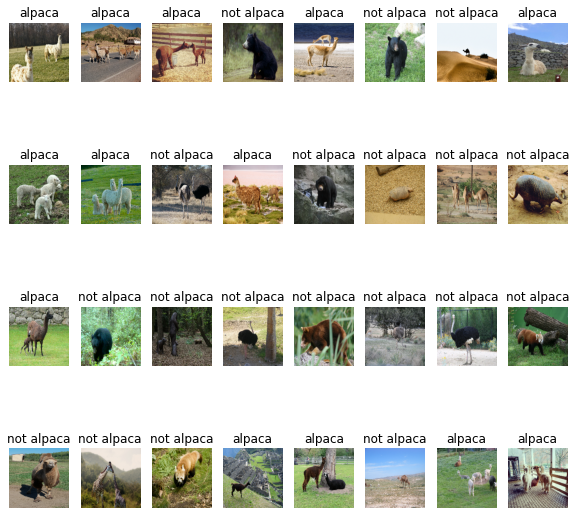

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
# You can get a piece of a data set using the take method; e.g. train_dataset.take(1) will retrieve one batch 
# (32 images with labels) from the training data.
for images, labels in train_dataset.take(1):
  for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 2 - Preprocess and Augment Training Data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Exercise 1 - data_augmenter

In [ ]:
def data_augmenter():

  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip("horizontal"))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)


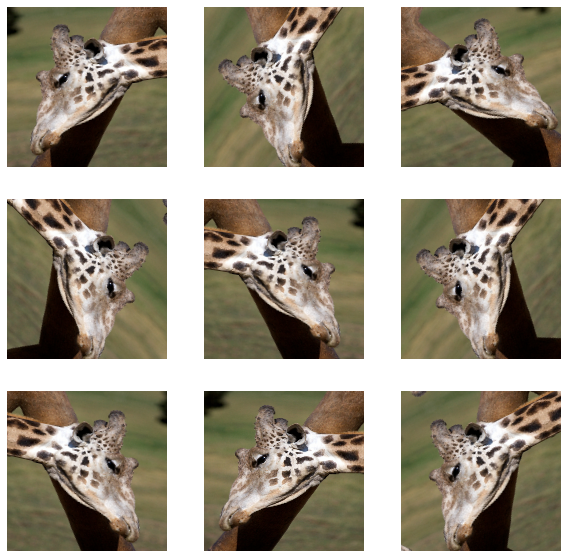

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  # print(first_image.shape) # (160, 160, 3)
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    print(augmented_image.shape) # (1, 160, 160, 3)
    # print(augmented_image[0].shape) # (160, 160, 3)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
data = (160, 160, 3)
data = tf.expand_dims(data, 0)
data[0].shape, data.shape

(TensorShape([3]), TensorShape([1, 3]))

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers-2].name)
print(base_model.layers[nb_layers-1].name)

global_average_pooling2d
predictions


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [ ]:
base_model.trainable=False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.425822),
  ('n02708093', 'analog_clock', 0.09275593)],
 [('n04589890', 'window_screen', 0.23985961),
  ('n03887697', 'paper_towel', 0.14802647)],
 [('n04589890', 'window_screen', 0.74494576),
  ('n03598930', 'jigsaw_puzzle', 0.021948503)],
 [('n04589890', 'window_screen', 0.33546028),
  ('n03530642', 'honeycomb', 0.0762893)],
 [('n04589890', 'window_screen', 0.27327326),
  ('n03733281', 'maze', 0.08846968)],
 [('n04589890', 'window_screen', 0.6745254),
  ('n03530642', 'honeycomb', 0.07659869)],
 [('n04589890', 'window_screen', 0.79128575),
  ('n04209239', 'shower_curtain', 0.09241592)],
 [('n04589890', 'window_screen', 0.16462986),
  ('n03598930', 'jigsaw_puzzle', 0.087491855)],
 [('n03598930', 'jigsaw_puzzle', 0.37021384),
  ('n04589890', 'window_screen', 0.09956942)],
 [('n04589890', 'window_screen', 0.6161673),
  ('n03887697', 'paper_towel', 0.054876637)],
 [('n03530642', 'honeycomb', 0.25448844),
  ('n04589890', 'window_screen', 0.24874416)],
 [('

### 3.2 - Layer Freezing with the Functional API


#### Exercise 2 - alpaca_model

In [ ]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet')
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)

  # Add the new Binary classification layers
  x = tfl.GlobalAveragePooling2D()(x)
  #include dropout with probability of 0.2 to avoid overfitting
  x = tfl.Dropout(0.2)(x)

  # create a prediction layer with one neuron (as a classifier only needs one)
  outputs = tfl.Dense(1)(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])


In [ ]:
initial_epoch=5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epoch)

Epoch 1/5
9/9 [==============================] - 16s 1s/step - loss: 0.7026 - accuracy: 0.6336 - val_loss: 0.1758 - val_accuracy: 0.9231
Epoch 2/5
9/9 [==============================] - 8s 719ms/step - loss: 0.2789 - accuracy: 0.8626 - val_loss: 0.1102 - val_accuracy: 0.9692
Epoch 3/5
9/9 [==============================] - 8s 696ms/step - loss: 0.2511 - accuracy: 0.8817 - val_loss: 0.1058 - val_accuracy: 0.9385
Epoch 4/5
9/9 [==============================] - 8s 705ms/step - loss: 0.1741 - accuracy: 0.9084 - val_loss: 0.0715 - val_accuracy: 0.9846
Epoch 5/5
9/9 [==============================] - 8s 706ms/step - loss: 0.1791 - accuracy: 0.9275 - val_loss: 0.0712 - val_accuracy: 0.9538


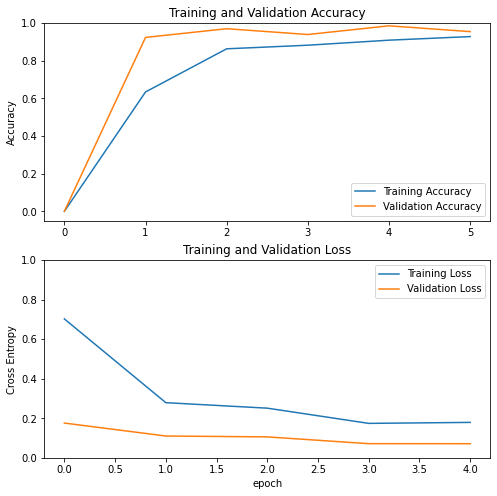

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
class_names

['alpaca', 'not alpaca']

### 3.3 - Fine-tuning the Model

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 126
"""
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
"""
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = None

loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
metrics = ['accuracy']

model2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

Number of layers in the base model:  156


In [ ]:
fine_tune_epoch = 5
total_epochs = initial_epoch + fine_tune_epoch
# total_epochs, fine_tune_epoch, initial_epoch

history_fine = model2.fit(train_dataset, 
                          epochs=total_epochs, 
                          initial_epoch=history.epoch[-1], 
                          validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 12s 784ms/step - loss: 0.1752 - accuracy: 0.9351 - val_loss: 0.0699 - val_accuracy: 0.9692
Epoch 6/10
9/9 [==============================] - 8s 671ms/step - loss: 0.1723 - accuracy: 0.9275 - val_loss: 0.0711 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 8s 675ms/step - loss: 0.1139 - accuracy: 0.9542 - val_loss: 0.0680 - val_accuracy: 0.9846
Epoch 8/10
9/9 [==============================] - 8s 680ms/step - loss: 0.1290 - accuracy: 0.9427 - val_loss: 0.0729 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 8s 690ms/step - loss: 0.1596 - accuracy: 0.9389 - val_loss: 0.0718 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 8s 698ms/step - loss: 0.1862 - accuracy: 0.9084 - val_loss: 0.0679 - val_accuracy: 0.9692


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

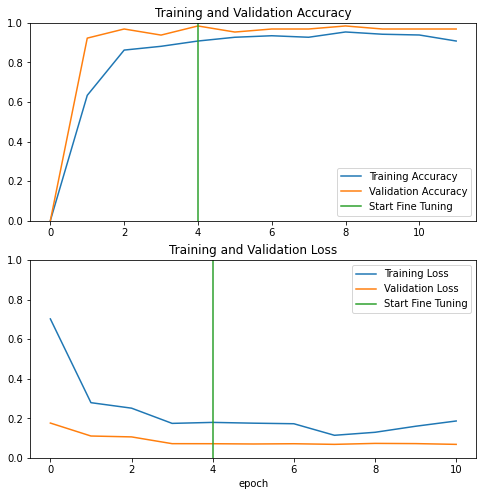

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()